https://arch.readthedocs.io/en/latest/univariate/introduction.html

### Get the data

In [2]:
!pip install yfinance arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

SPY = yf.Ticker('SPY')
df = SPY.history(start="2010-01-01", end="2018-12-31")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-21 00:00:00-05:00,231.903288,234.694700,225.549764,226.226471,255345600,1.435,0
2018-12-24 00:00:00-05:00,224.666283,226.358050,220.183118,220.248901,147311600,0.000,0
2018-12-26 00:00:00-05:00,221.780942,231.376999,219.703825,231.376999,218485400,0.000,0
2018-12-27 00:00:00-05:00,227.984041,233.360078,224.591113,233.153320,186267300,0.000,0
2018-12-28 00:00:00-05:00,234.572501,236.283055,231.630707,232.852539,153100200,0.000,0


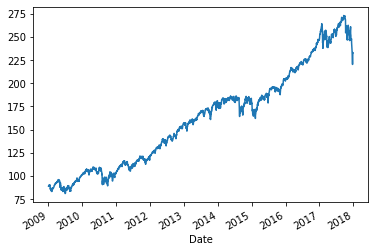

In [4]:
df['Close'].plot();

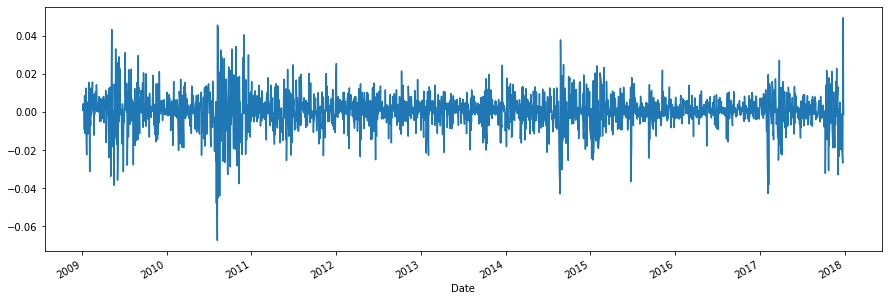

In [5]:
df['LogRet'] = np.log(df['Close']).diff()
df['LogRet'].plot(figsize=(15, 5));

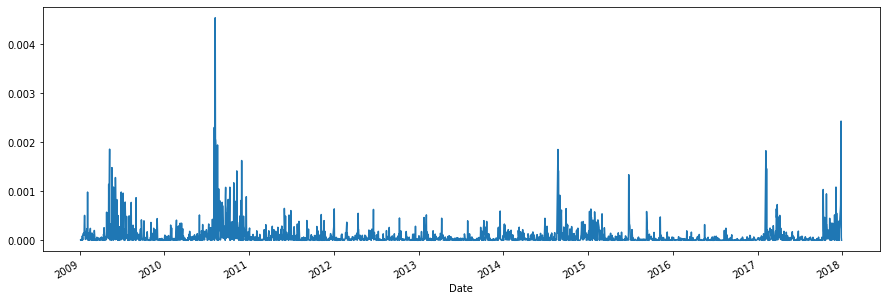

In [6]:
(df['LogRet']**2).plot(figsize=(15, 5));

### ACF and PACF

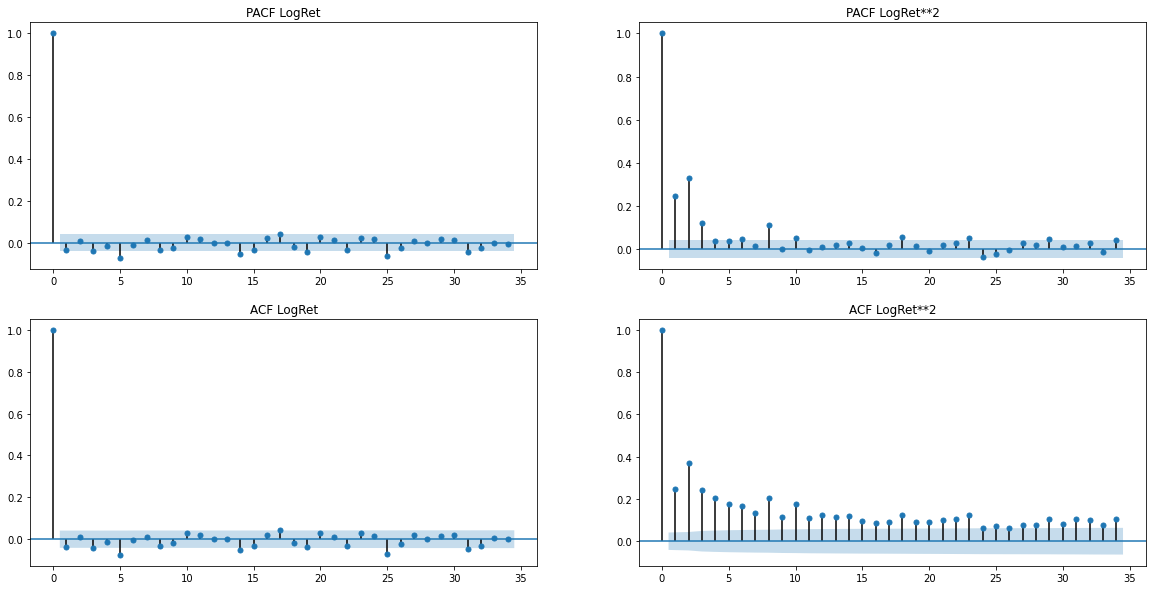

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for LogRet & LogRet**2
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plot_pacf(df['LogRet'].dropna(), ax=ax[0,0], title='PACF LogRet');
plot_pacf((df['LogRet']**2).dropna(), ax=ax[0,1], title='PACF LogRet**2');
plot_acf(df['LogRet'].dropna(), ax=ax[1,0], title='ACF LogRet');
plot_acf((df['LogRet']**2).dropna(), ax=ax[1,1], title='ACF LogRet**2');

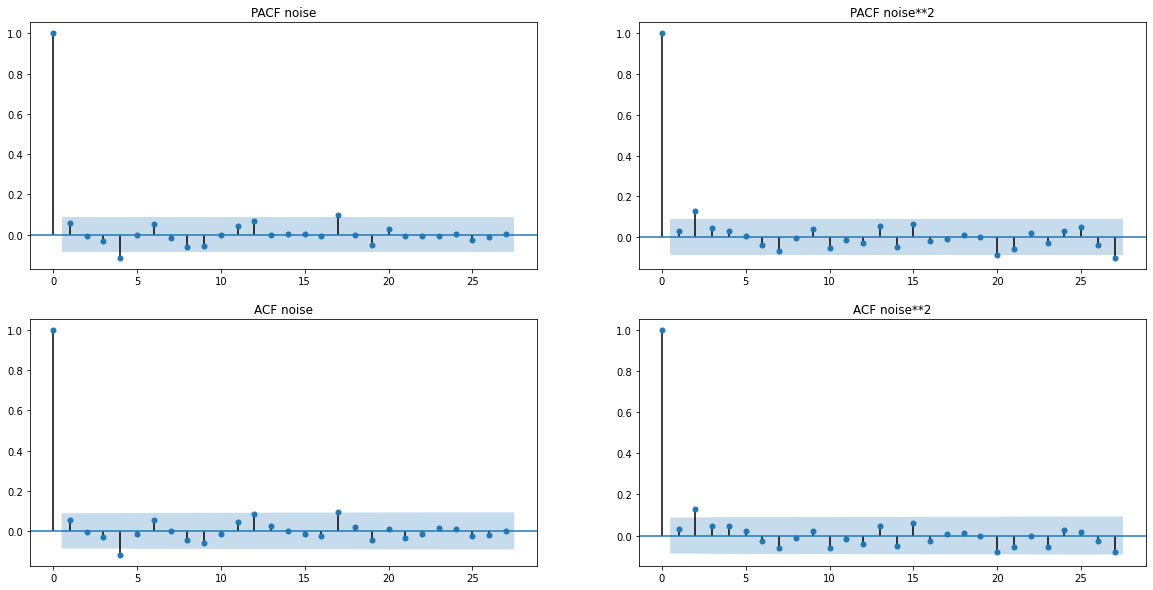

In [ ]:
# Compare against random noise
noise = np.random.randn(500)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plot_pacf(noise, ax=ax[0,0], title='PACF noise');
plot_pacf(noise**2, ax=ax[0,1], title='PACF noise**2');
plot_acf(noise, ax=ax[1,0], title='ACF noise');
plot_acf(noise**2, ax=ax[1,1], title='ACF noise**2');

### Train-test split

In [7]:
import math
from sklearn.preprocessing import StandardScaler

test_size = 0.2
Ntest = math.floor(len(df)*0.2)
train = df.iloc[1:-Ntest][['LogRet']]
test = df.iloc[-Ntest:][['LogRet']]

scaler = StandardScaler()
scaler.fit(train)
train['LogRet'] = scaler.fit_transform(train[['LogRet']])
test['LogRet'] = scaler.transform(test[['LogRet']])

print(f'Ntest={Ntest}')

Ntest=452


### ARCH(1)

In [ ]:
from arch import arch_model

arch1 = arch_model(train['LogRet'], mean='Constant', vol='ARCH', p=1)
res_arch1 = arch1.fit(update_freq=1)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 165844.248210098
Iteration:      2,   Func. Count:     13,   Neg. LLF: 2820.419045183264
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2577.0045869456735
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2521.6450680796797
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2521.6450680795733
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2521.6450680796797
            Iterations: 5
            Function evaluations: 29
            Gradient evaluations: 5


In [ ]:
res_arch1.summary()
#res_arch1.plot();

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 LogRet   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2521.65
Distribution:                  Normal   AIC:                           5049.29
Method:            Maximum Likelihood   BIC:                           5065.79
                                        No. Observations:                 1810
Date:                Sat, Oct 08 2022   Df Residuals:                     1809
Time:                        09:35:35   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0142  2.298e-02      0.616      0.538 [-3.088e-02,5.919e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8070  6.825e-02     11.825  2.892e-32   [  0.673,  0.941]
alpha[1]       0.1919  5.065e-02      3.790  1.508e-04 [9.267e-02,  0.291]
==========================================================================

Covariance estimator: robust
"""

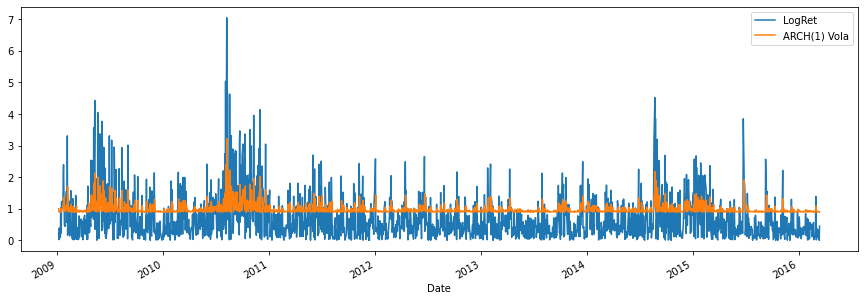

In [ ]:
# Compare vola with train set (absolute values to focus on volatility)
train['ARCH(1) Vola'] = res_arch1.conditional_volatility
np.abs(train[['LogRet','ARCH(1) Vola']]).plot(figsize=(15,5));

vola (params)   = 0.9987
vola (forecast) = 0.9994



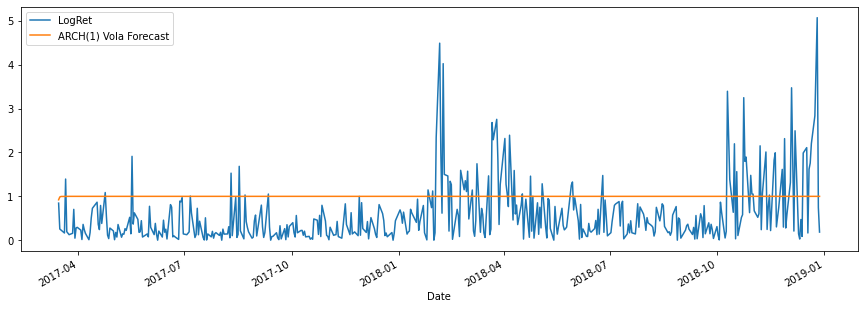

In [ ]:
# Forecast vola from last data point
forecast_arch1 = res_arch1.forecast(horizon=Ntest, reindex=False)
vola_arch1 = np.sqrt(forecast_arch1.variance.iloc[-1].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_arch1.params['omega'] / (1 - res_arch1.params['alpha[1]']):.4f}")
print(f"vola (forecast) = {vola_arch1[-1]:.4f}")
print()

# Compare forecast with test set
test['ARCH(1) Vola Forecast'] = vola_arch1
np.abs(test[['LogRet', 'ARCH(1) Vola Forecast']]).plot(figsize=(15,5));

vola (params)   = 0.9987
vola (forecast high) = 0.9994
vola (forecast low) = 0.9994



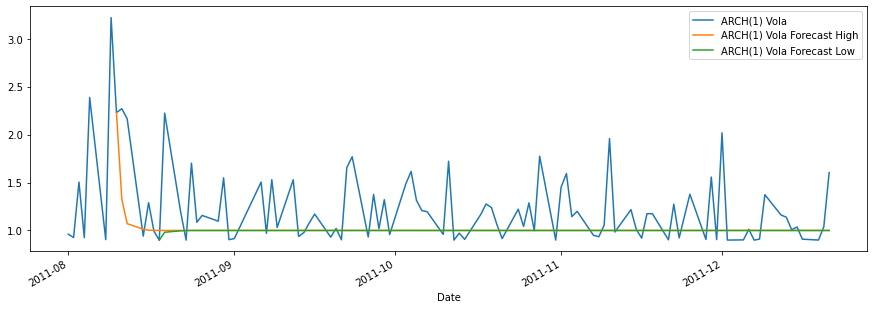

In [ ]:
# Forecast from data points with different conditional volatility, and compare.
# The two forecasts quickly converge to the same value, since this is an ARCH model.
start_date = '2011-08-01'
high_date = '2011-08-09'
low_date = '2011-08-17'
forecast_arch1 = res_arch1.forecast(horizon=Ntest, reindex=True, start=start_date)
high_start = train.index[train.index.get_loc(high_date) + 1]  # start of forecast horizon
high_end = train.index[train.index.get_loc(high_date) + Ntest]  # end of forecast horizon
low_start = train.index[train.index.get_loc(low_date) + 1]  # start of forecast horizon
low_end = train.index[train.index.get_loc(low_date) + Ntest]  # end of forecast horizon
vola_high_arch1 = np.sqrt(forecast_arch1.variance.loc[high_date].to_numpy())
vola_low_arch1 = np.sqrt(forecast_arch1.variance.loc[low_date].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_arch1.params['omega'] / (1 - res_arch1.params['alpha[1]']):.4f}")
print(f"vola (forecast high) = {vola_high_arch1[-1]:.4f}")
print(f"vola (forecast low) = {vola_low_arch1[-1]:.4f}")
print()

# Plot
start_date = train.index[train.index.get_loc(start_date)]  # convert to datetime for slicing
end_date = train.index[train.index.get_loc(start_date) + 100]
train.loc[high_start:high_end,'ARCH(1) Vola Forecast High'] = vola_high_arch1
train.loc[low_start:low_end,'ARCH(1) Vola Forecast Low'] = vola_low_arch1
train.loc[start_date:end_date, ['ARCH(1) Vola', 'ARCH(1) Vola Forecast High', 'ARCH(1) Vola Forecast Low']].plot(figsize=(15,5));

### GARCH(1,1)

In [ ]:
from arch import arch_model

garch11 = arch_model(train['LogRet'], mean='Constant', vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit(update_freq=1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 509934.4428159342
Iteration:      2,   Func. Count:     15,   Neg. LLF: 32134504302.452995
Iteration:      3,   Func. Count:     23,   Neg. LLF: 3524.1881358377577
Iteration:      4,   Func. Count:     30,   Neg. LLF: 3116.3766576606986
Iteration:      5,   Func. Count:     36,   Neg. LLF: 2327.432424649943
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2317.6442902961003
Iteration:      7,   Func. Count:     47,   Neg. LLF: 2317.4658462595976
Iteration:      8,   Func. Count:     52,   Neg. LLF: 2317.452826135817
Iteration:      9,   Func. Count:     57,   Neg. LLF: 2317.4512235707193
Iteration:     10,   Func. Count:     62,   Neg. LLF: 2317.4505909523486
Iteration:     11,   Func. Count:     67,   Neg. LLF: 2317.450590260206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2317.450590260206
            Iterations: 11
            Function evaluations: 67
            Gradient evaluati

In [ ]:
res_garch11.summary()
# res_garch11.plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 LogRet   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2317.45
Distribution:                  Normal   AIC:                           4642.90
Method:            Maximum Likelihood   BIC:                           4664.91
                                        No. Observations:                 1810
Date:                Sat, Oct 08 2022   Df Residuals:                     1809
Time:                        09:32:27   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0302  1.829e-02      1.652  9.845e-02 [-5.624e-03,6.606e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0450  1.078e-02      4.180  2.919e-05 [2.392e-02,6.616e-02]
alpha[1]       0.1532  2.603e-02      5.884  4.008e-09     [  0.102,  0.204]
beta[1]        0.8011  2.709e-02     29.577 2.960e-192     [  0.748,  0.854]
============================================================================

Covariance estimator: robust
"""

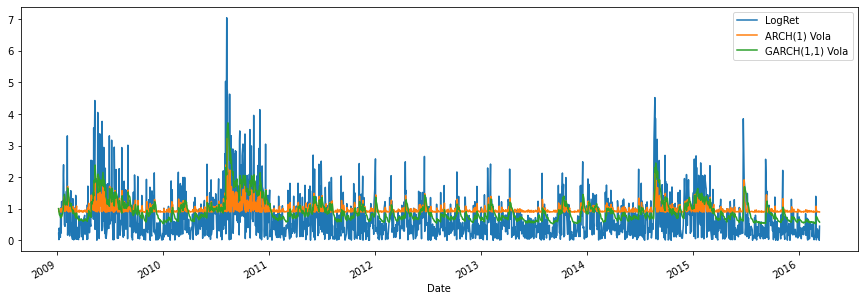

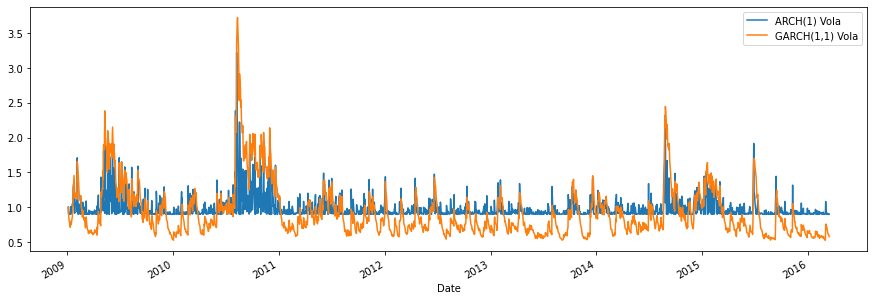

In [ ]:
# Compare with ARCH(1) and with train set (absolute values to focus on volatility)
train['GARCH(1,1) Vola'] = res_garch11.conditional_volatility
np.abs(train[['LogRet','ARCH(1) Vola','GARCH(1,1) Vola']]).plot(figsize=(15,5));
train[['ARCH(1) Vola','GARCH(1,1) Vola']].plot(figsize=(15,5));

vola (params)   = 0.9862
vola (forecast) = 0.9931



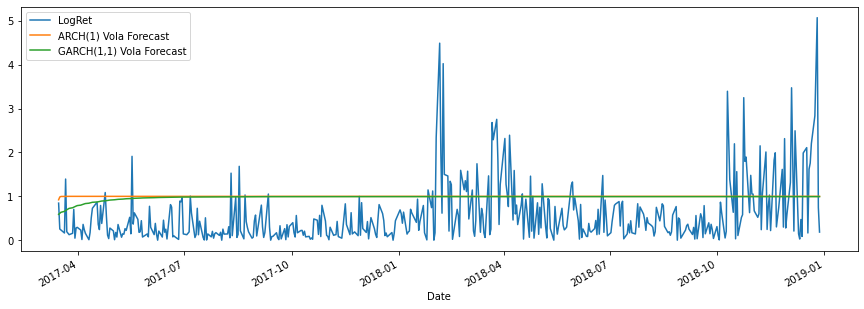

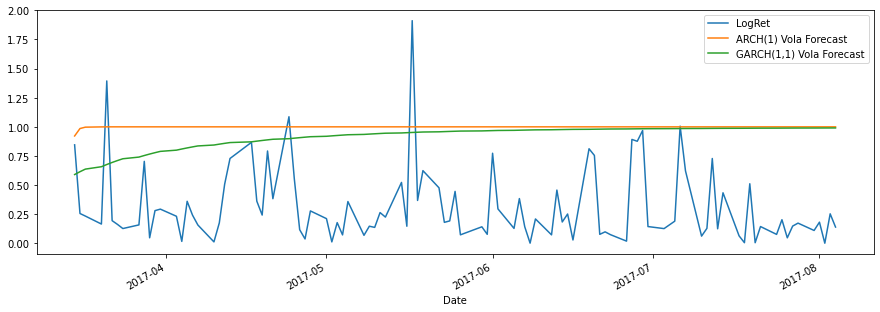

In [ ]:
# Forecast vola from last data point
forecast_garch11 = res_garch11.forecast(horizon=Ntest, reindex=False)
vola_garch11 = np.sqrt(forecast_garch11.variance.iloc[-1].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_garch11.params['omega'] / (1 - res_garch11.params['alpha[1]'] - res_garch11.params['beta[1]']):.4f}")
print(f"vola (forecast) = {vola_garch11[-1]:.4f}")
print()

# Compare to test set
test['GARCH(1,1) Vola Forecast'] = vola_garch11
np.abs(test[['LogRet', 'ARCH(1) Vola Forecast', 'GARCH(1,1) Vola Forecast']]).plot(figsize=(15,5));
np.abs(test[['LogRet', 'ARCH(1) Vola Forecast', 'GARCH(1,1) Vola Forecast']].iloc[:100]).plot(figsize=(15,5));

vola (params)   = 0.9862
vola (forecast high) = 0.9931
vola (forecast low) = 0.9931



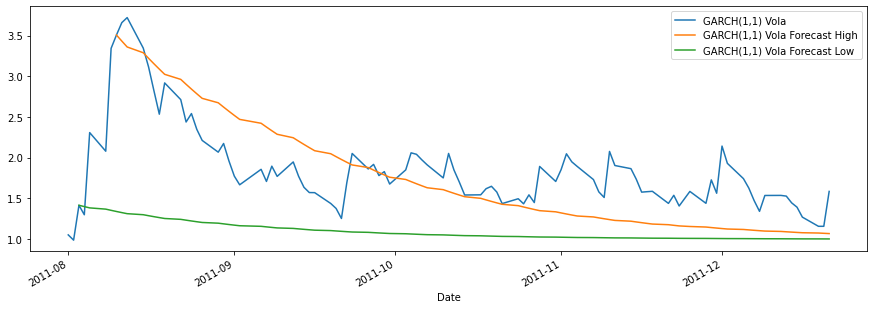

In [ ]:
# Forecast from data points with different conditional volatility, and compare.
# The two forecasts quickly converge to the same value, since this is an ARCH model.
start_date = '2011-08-01'
high_date = '2011-08-09'
low_date = '2011-08-02'
forecast_garch11 = res_garch11.forecast(horizon=Ntest, reindex=True, start=start_date)
high_start = train.index[train.index.get_loc(high_date) + 1]  # start of forecast horizon
high_end = train.index[train.index.get_loc(high_date) + Ntest]  # end of forecast horizon
low_start = train.index[train.index.get_loc(low_date) + 1]  # start of forecast horizon
low_end = train.index[train.index.get_loc(low_date) + Ntest]  # end of forecast horizon
vola_high_garch11 = np.sqrt(forecast_garch11.variance.loc[high_date].to_numpy())
vola_low_garch11 = np.sqrt(forecast_garch11.variance.loc[low_date].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_garch11.params['omega'] / (1 - res_garch11.params['alpha[1]'] - res_garch11.params['beta[1]']):.4f}")
print(f"vola (forecast high) = {vola_high_garch11[-1]:.4f}")
print(f"vola (forecast low) = {vola_low_garch11[-1]:.4f}")
print()

# Plot
start_date = train.index[train.index.get_loc(start_date)]  # convert to datetime for slicing
end_date = train.index[train.index.get_loc(start_date) + 100]
train.loc[high_start:high_end,'GARCH(1,1) Vola Forecast High'] = vola_high_garch11
train.loc[low_start:low_end,'GARCH(1,1) Vola Forecast Low'] = vola_low_garch11
train.loc[start_date:end_date, ['GARCH(1,1) Vola', 'GARCH(1,1) Vola Forecast High', 'GARCH(1,1) Vola Forecast Low']].plot(figsize=(15,5));

### GARCH(1,1) with t-Student

In [ ]:
from arch import arch_model

garch11t = arch_model(train['LogRet'], mean='Constant', vol='GARCH', p=1, q=1,
                      dist='StudentsT')
res_garch11t = garch11t.fit(update_freq=1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 123778.9470948489
Iteration:      2,   Func. Count:     17,   Neg. LLF: 52953.286836289655
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4674.118621104411
Iteration:      4,   Func. Count:     32,   Neg. LLF: 4131.38547093209
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3651.6027114434173
Iteration:      6,   Func. Count:     47,   Neg. LLF: 2275.3557866156316
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2305.0590750959445
Iteration:      8,   Func. Count:     61,   Neg. LLF: 2272.224070036973
Iteration:      9,   Func. Count:     67,   Neg. LLF: 2272.1934638046628
Iteration:     10,   Func. Count:     73,   Neg. LLF: 2272.193064584042
Iteration:     11,   Func. Count:     79,   Neg. LLF: 2272.1928956425904
Iteration:     12,   Func. Count:     85,   Neg. LLF: 2272.192873451828
Iteration:     13,   Func. Count:     91,   Neg. LLF: 2272.1928724652057
Optimization terminated successfully    (Exit mode 0)
    

In [ ]:
res_garch11t.summary()
# res_garch11t.plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                       LogRet   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2272.19
Distribution:      Standardized Student's t   AIC:                           4554.39
Method:                  Maximum Likelihood   BIC:                           4581.89
                                              No. Observations:                 1810
Date:                      Sat, Oct 08 2022   Df Residuals:                     1809
Time:                              09:41:29   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0468  1.623e-02      2.881  3.962e-03 [1.495e-02,7.856e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0368  9.108e-03      4.035  5.450e-05 [1.890e-02,5.461e-02]
alpha[1]       0.1657  2.609e-02      6.354  2.102e-10     [  0.115,  0.217]
beta[1]        0.8089  2.475e-02     32.682 2.804e-234     [  0.760,  0.857]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.3647      0.664      8.082  6.356e-16 [  4.064,  6.666]
========================================================================

Covariance estimator: robust
"""

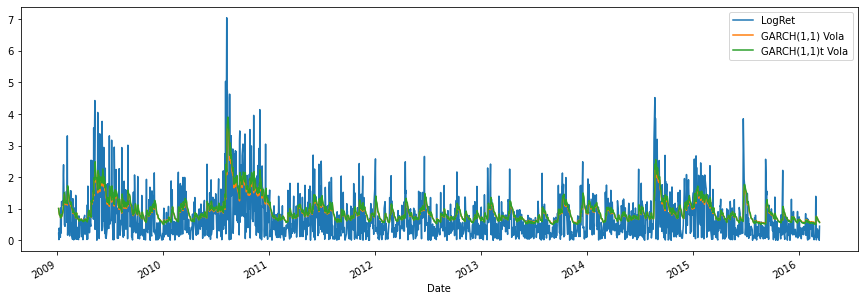

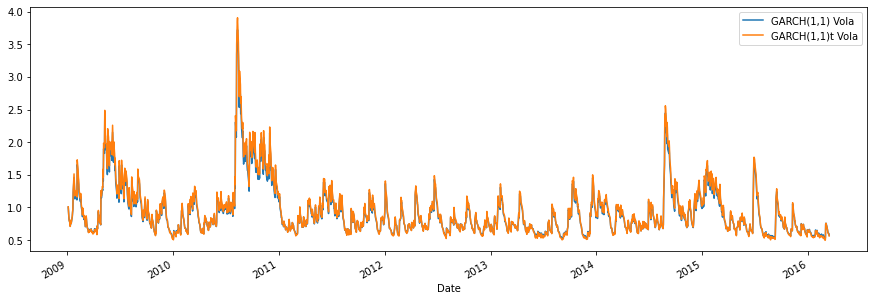

In [ ]:
# Compare with GARCH(1,1) and with train set (absolute values to focus on volatility)
train['GARCH(1,1)t Vola'] = res_garch11t.conditional_volatility
np.abs(train[['LogRet','GARCH(1,1) Vola','GARCH(1,1)t Vola']]).plot(figsize=(15,5));
train[['GARCH(1,1) Vola','GARCH(1,1)t Vola']].plot(figsize=(15,5));

vola (params)   = 1.4476
vola (forecast) = 1.2032



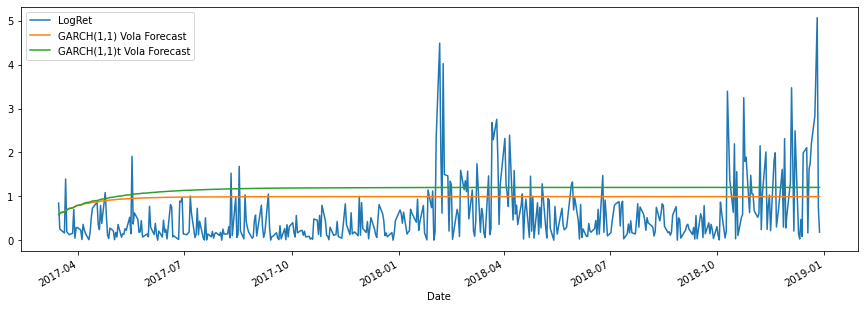

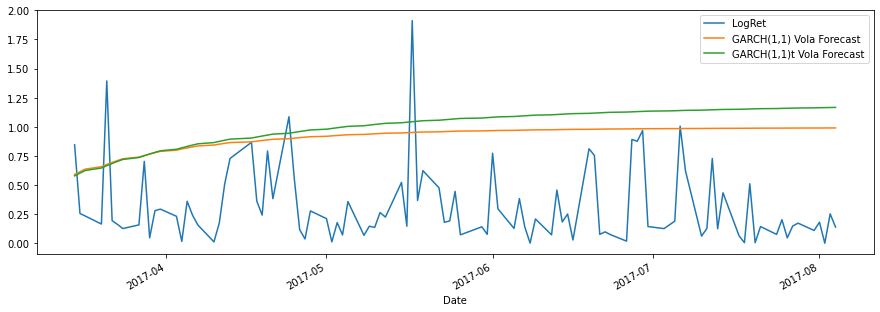

In [ ]:
# Forecast vola from last data point
forecast_garch11t = res_garch11t.forecast(horizon=Ntest, reindex=False)
vola_garch11t = np.sqrt(forecast_garch11t.variance.iloc[-1].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_garch11t.params['omega'] / (1 - res_garch11t.params['alpha[1]'] - res_garch11t.params['beta[1]']):.4f}")
print(f"vola (forecast) = {vola_garch11t[-1]:.4f}")
print()

# Compare with test set
test['GARCH(1,1)t Vola Forecast'] = vola_garch11t
np.abs(test[['LogRet', 'GARCH(1,1) Vola Forecast', 'GARCH(1,1)t Vola Forecast']]).plot(figsize=(15,5));
np.abs(test[['LogRet', 'GARCH(1,1) Vola Forecast', 'GARCH(1,1)t Vola Forecast']].iloc[:100]).plot(figsize=(15,5));

vola (params)   = 1.4476
vola (forecast high) = 1.2032
vola (forecast low) = 1.2032



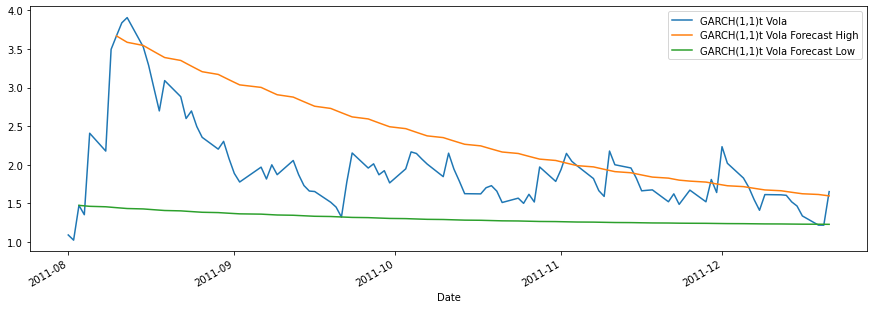

In [ ]:
# Forecast from data points with different conditional volatility, and compare.
# The two forecasts quickly converge to the same value, since this is an ARCH model.
start_date = '2011-08-01'
high_date = '2011-08-09'
low_date = '2011-08-02'
forecast_garch11t = res_garch11t.forecast(horizon=Ntest, reindex=True, start=start_date)
high_start = train.index[train.index.get_loc(high_date) + 1]  # start of forecast horizon
high_end = train.index[train.index.get_loc(high_date) + Ntest]  # end of forecast horizon
low_start = train.index[train.index.get_loc(low_date) + 1]  # start of forecast horizon
low_end = train.index[train.index.get_loc(low_date) + Ntest]  # end of forecast horizon
vola_high_garch11t = np.sqrt(forecast_garch11t.variance.loc[high_date].to_numpy())
vola_low_garch11t = np.sqrt(forecast_garch11t.variance.loc[low_date].to_numpy())

# Check: forecasted asymptotic vola = unconditional theoretical vola
print(f"vola (params)   = {res_garch11t.params['omega'] / (1 - res_garch11t.params['alpha[1]'] - res_garch11t.params['beta[1]']):.4f}")
print(f"vola (forecast high) = {vola_high_garch11t[-1]:.4f}")
print(f"vola (forecast low) = {vola_low_garch11t[-1]:.4f}")
print()

# Plot
start_date = train.index[train.index.get_loc(start_date)]  # convert to datetime for slicing
end_date = train.index[train.index.get_loc(start_date) + 100]
train.loc[high_start:high_end,'GARCH(1,1)t Vola Forecast High'] = vola_high_garch11t
train.loc[low_start:low_end,'GARCH(1,1)t Vola Forecast Low'] = vola_low_garch11t
train.loc[start_date:end_date, ['GARCH(1,1)t Vola', 'GARCH(1,1)t Vola Forecast High', 'GARCH(1,1)t Vola Forecast Low']].plot(figsize=(15,5));

### Variance simulation

https://arch.readthedocs.io/en/latest/univariate/forecasting.html

Iteration:     10,   Func. Count:     73,   Neg. LLF: 2272.1937554842325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2272.1935602203275
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


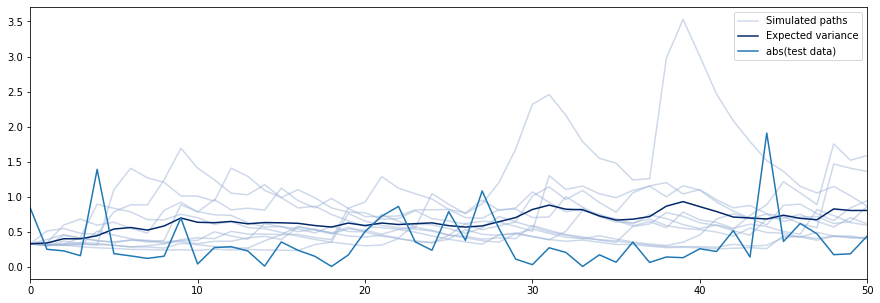

In [19]:
from arch import arch_model

# The volatility is a stochastic process, since it depends on past residuals
# z_{t-1} that are random noise N(0,1):
#    sigma2_t = omega + (alpha_1 * z_{t-1}**2 + beta_1) * sigma2_{t-1}
# We can simulate possible paths with realizations of the residuals z_t.
# With arch packages, this is implemented in the forecast function directly,
# with method='simulation'
horizon = 51
n_sims = 10
garch11t = arch_model(train['LogRet'], mean='Constant', vol='GARCH', p=1, q=1,
                      dist='studentst')
res_garch11t = garch11t.fit(update_freq=10)
forecast_garch11t = res_garch11t.forecast(horizon=horizon, reindex=False,
                                          method='simulation', simulations=n_sims)
sims_garch11t = forecast_garch11t.simulations

x = np.arange(horizon)
plt.figure(figsize=(15,5))
lines = plt.plot(x, sims_garch11t.residual_variances[-1].T, color="#9cb2d6", alpha=0.5)
lines[0].set_label("Simulated paths")
line = plt.plot(x, forecast_garch11t.variance.iloc[-1].values, color="#002868")
line[0].set_label("Expected variance")
data = plt.plot(np.abs(test['LogRet'].to_numpy())[:horizon])
data[0].set_label("abs(test data)")
plt.gca().set_xticks(x[::10])
plt.gca().set_xlim(0, horizon-1)
legend = plt.legend()

### Return simulation

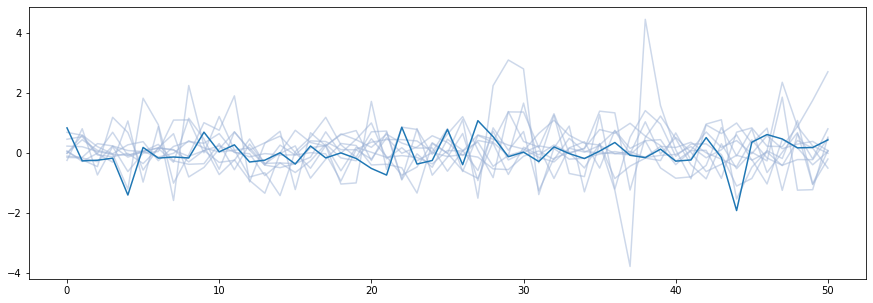

In [20]:
# From the simulated variances, we can simulate paths of (scaled) log-returns:
#    r_t = mu + sigma_t * z_t
# where z_t are the simulated residuals.
sigmas = np.sqrt(sims_garch11t.residual_variances[-1].transpose())
residuals = sims_garch11t.residuals[-1].transpose()
returns = res_garch11t.params['mu'] + residuals * sigmas  # scaled log-returns
plt.figure(figsize=(15,5))
plt.plot(returns, color="#9cb2d6", alpha=0.5)
plt.plot(test['LogRet'].to_numpy()[:horizon]);

https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Simulation

In [17]:
# From the model, we can simulate returns.
# This is not a forecast, but a simulation with the same model parameters as 
# the fitted GARCH model.
sims = garch11t.simulate(res_garch11t.params, 1000)
sims.head()

,data,volatility,errors
0,-0.108324,1.127761,-0.155081
1,-1.051248,1.034161,-1.098005
2,0.622239,1.049597,0.575482
3,0.030507,0.991329,-0.016250
4,-0.568395,0.911974,-0.615152


### (Playground)

In [46]:
mu = res_garch11t.params['mu']
omega = res_garch11t.params['omega']
alpha1 = res_garch11t.params['alpha[1]']
beta1 = res_garch11t.params['beta[1]']

In [47]:
# TODO 1: check how the expected variances are derived from the parameters
expected_variances = forecast_garch11t.variance.iloc[-1].values
print(omega + (alpha1 + beta1) * expected_variances[0])
print(expected_variances[1])
# where is mu used? try zero mean model too!

0.362629004804437
0.34568848486663906


In [44]:
# TODO 2: check how the simulated variances are calculated from the residuals and the parameters
residuals = sims_garch11t.residuals[-1,0]
variances = np.zeros(horizon)
variances[0] = sims_garch11t.residual_variances[-1,0,0]  # init
for i in range(1, horizon):
  variances[i] = omega + (alpha1 * residuals[i]**2 + beta1) * variances[i-1]
print(variances)
# check against: sims_garch11t.residual_variances[-1,0]
print(sims_garch11t.residual_variances[-1,0])

[0.33436207 0.39470642 0.35710722 0.32813391 1.11718191 1.41902252
 1.28078621 1.21501617 1.02104082 1.01656842 0.94350223 1.41288157
 1.29730528 1.09659741 0.99468363 1.1054141  0.9916015  0.84558624
 0.78437606 0.77748949 0.68371198 0.69398797 0.80797147 0.6912028
 0.65946194 0.61494611 0.53480586 0.58952222 0.64518598 0.57750917
 0.50402484 0.45735824 0.41115627 0.39319415 0.37421646 0.34194901
 0.31338815 0.29388444 0.29403092 0.29289459 0.285623   0.32659566
 0.30148625 0.3130992  0.42154485 0.44072626 0.40914313 0.44864662
 0.42433794 0.4066482  0.44710651]
[0.33436207 0.30814958 0.37350415 0.33995752 0.31426217 1.1059616
 1.40994684 1.27344525 1.20907834 1.01623795 1.01268356 0.94035991
 1.41033987 1.2952494  1.09493448 0.99333856 1.10432612 0.99072148
 0.84487442 0.78380029 0.77702377 0.68333528 0.69368327 0.80772501
 0.69100345 0.65930069 0.61481569 0.53470037 0.58943689 0.64511696
 0.57745334 0.50397968 0.45732171 0.41112672 0.39317025 0.37419713
 0.34193338 0.31337551 0.2938